<a href="https://colab.research.google.com/github/jiwooya1000/KOR-Multimodal-Emotion-Recognition/blob/main/4.%20Multimodal%20Emotion%20Classifier/%EB%A9%80%ED%8B%B0%EB%AA%A8%EB%8B%AC_%ED%95%99%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers==3.0.2
!pip install torch
!pip install git+https://git@github.com/SKTBrain/KoBERT.git@master
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'
!pip install torchmetrics

     |████████████████████████████████| 47.3 MB 1.1 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 344 kB 8.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595738 sha256=74e12295cb3a99cff09b294266d89c173a1516bbd654c1fa53318c4a2b068b87
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 1.2 MB 8.2 MB/s 
     |████████████████████████████████| 769 kB 7.3 MB/s 
     |████████████████████████████████| 880 kB 70.9 MB/s 
     |████████████████████████████████| 3.0 MB 72.2 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=b793bb258315f5a1d544c268bdf50a0115e0c469c900e235894d329a8bae776a
  Stored in directory: /root/.

In [ ]:
import torch
import time
import os
import pandas as pd
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import gluonnlp as nlp
import matplotlib.pyplot as plt
from tqdm import tqdm
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertTokenizer, BertModel
from kobert import get_pytorch_kobert_model
from sklearn.metrics import f1_score

In [ ]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

directory = "paper_comp/멀티모달최종"
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
datapath = "/content/gdrive/My Drive/paper_comp/data/"

## **1. 데이터로더 준비**

In [ ]:
# KoBERT tokenizer 불러오기
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
# Custom Dataset 불러오기
from dataloader import *

In [ ]:
# Custom Dataset 객체 생성(Train Set)
dataset_train = KEMDset(file=f'{datapath}train_aft_aug_kobert.pickle', tokenizer=tokenizer, balance=False, shuffle=True)
# DataLoader 정의
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=16,
                                               shuffle=False, drop_last=True)

100%|██████████| 10043/10043 [00:05<00:00, 1805.02it/s]


In [ ]:
# Custom Dataset 객체 생성(Valid Set)
dataset_valid = KEMDset(file=f'{datapath}valid_tokenized.pickle', tokenizer=tokenizer, balance=False, shuffle=True)
# DataLoader 정의
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=16,
                                               shuffle=False, drop_last=True)

100%|██████████| 1018/1018 [00:00<00:00, 1864.59it/s]


In [ ]:
# Custom Dataset 객체 생성(Test Set)
dataset_test = KEMDset(file=f'{datapath}test_tokenized.pickle', tokenizer=tokenizer, balance=False, shuffle=True)
# DataLoader 정의
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=16,
                                               shuffle=False, drop_last=True)

100%|██████████| 2545/2545 [00:01<00:00, 1870.16it/s]


## **2. 모델**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# 정의한 모듈 불러오기
import importlib
import combined_model
importlib.reload(combined_model)
from combined_model import *
from EarlyStopping import *

In [ ]:
# 모델 객체 생성
model = EmoClassifier(n_layers=4).to(device)

using cached model. /content/gdrive/My Drive/paper_comp/멀티모달최종/.cache/kobert_v1.zip
using cached model. /content/gdrive/My Drive/paper_comp/멀티모달최종/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


## **3. 학습**

In [ ]:
# 하이퍼 파라미터 설정
learning_rate = 2e-5 
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8) 

In [ ]:
# 가중치 설정
neutral_count = len(dataset_train.file.index[dataset_train.file['Emotion'] == 'neutral'].tolist())
sad_count = len(dataset_train.file.index[dataset_train.file['Emotion'] == 'sad'].tolist())
happy_count = len(dataset_train.file.index[dataset_train.file['Emotion'] == 'happy'].tolist())
surprise_count = len(dataset_train.file.index[dataset_train.file['Emotion'] == 'surprise'].tolist())
angry_count = len(dataset_train.file.index[dataset_train.file['Emotion'] == 'angry'].tolist())

min_count = min(neutral_count, sad_count, happy_count, surprise_count, angry_count)

w_list = [min_count / neutral_count,
          min_count / sad_count,
          min_count / happy_count,
          min_count / surprise_count,
          min_count / angry_count] 

In [ ]:
# 모델 학습

epochs=30 

train_losses = []
train_acces = []
train_f1s = []
valid_losses = []
valid_acces = []
valid_f1s = []

start_time = time.time()
es = EarlyStopping(patience=8, path='Multi_Modal_Classifier_ye.pt')

for epoch in range(epochs):
    
    #########
    # Train #
    #########
    model.train()
    train_loss = 0
    train_acc = 0
    train_f1 = 0
    
    for i, dict in enumerate(dataloader_train):
        audio = dict['audio'].to(device=device, dtype=torch.float32)
        input_ids = dict['input_ids'].to(device=device, dtype=torch.int32)
        token_type_ids = dict['token_type_ids'].to(device=device, dtype=torch.int32)
        attention_mask = dict['attention_mask'].to(device=device, dtype=torch.int32)
        targets = dict['emotion'].to(device=device, dtype=torch.long)

        scores, arousal, valence = model(audio, input_ids, token_type_ids, attention_mask)
        _, preds = scores.max(dim=1)
        
        # 가중치 설정 (weight=loss_weight)
        loss_fn = nn.CrossEntropyLoss() 
        loss = loss_fn(scores, targets)

        train_loss += loss
        train_acc += (targets == preds).sum() / preds.size(0)
        train_f1 += f1_score(targets.detach().cpu().numpy(), 
                             preds.detach().cpu().numpy(),
                             average='weighted') # f1(preds, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()
        
    ##############
    # Validation #
    ##############
    model.eval()
    valid_loss = 0
    valid_acc = 0
    valid_f1 = 0

    with torch.no_grad():
        for i, dict in enumerate(dataloader_valid):
            audio = dict['audio'].to(device=device, dtype=torch.float32)
            input_ids = dict['input_ids'].to(device=device, dtype=torch.int32)
            token_type_ids = dict['token_type_ids'].to(device=device, dtype=torch.int32)
            attention_mask = dict['attention_mask'].to(device=device, dtype=torch.int32)
            targets = dict['emotion'].to(device=device, dtype=torch.long)
  
            scores, arousal, valence = model(audio, input_ids, token_type_ids, attention_mask)
            _, preds = scores.max(dim=1)

            valid_loss += loss_fn(scores, targets)
            valid_acc += (targets == preds).sum() / preds.size(0)
            valid_f1 += f1_score(targets.detach().cpu().numpy(), 
                             preds.detach().cpu().numpy(),
                             average='weighted')
            
    #######
    # Log #
    #######
    train_losses.append(train_loss.detach().cpu().numpy() / len(dataloader_train))
    train_acces.append(train_acc.detach().cpu().numpy() / len(dataloader_train))
    train_f1s.append(train_f1 / len(dataloader_train))
    valid_losses.append(valid_loss.detach().cpu().numpy() / len(dataloader_valid))
    valid_acces.append(valid_acc.detach().cpu().numpy() / len(dataloader_valid))
    valid_f1s.append(valid_f1 / len(dataloader_valid))

    elapsed_time = time.time() - start_time

    print(f"[{time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}] Epoch {epoch+1:2d} \
    Train Loss: {train_losses[-1]:6.4f} Train Acc: {train_acces[-1]:6.4f} Train F1 Score: {train_f1s[-1]:6.4f} \
    Valid Loss: {valid_losses[-1]:6.4f} Valid Acc: {valid_acces[-1]:6.4f} Valid F1 Score: {valid_f1s[-1]:6.4f}")
    
    es(valid_losses[-1], model)

    if es.early_stop:
        print('Early Stopping Activated!')
        break

[00:05:07] Epoch  1     Train Loss: 0.6147 Train Acc: 0.8215 Train F1 Score: 0.7575     Valid Loss: 0.4327 Valid Acc: 0.8661 Valid F1 Score: 0.8112
[00:10:16] Epoch  2     Train Loss: 0.4470 Train Acc: 0.8590 Train F1 Score: 0.8275     Valid Loss: 0.4144 Valid Acc: 0.8730 Valid F1 Score: 0.8237
[00:15:26] Epoch  3     Train Loss: 0.3977 Train Acc: 0.8752 Train F1 Score: 0.8505     Valid Loss: 0.4155 Valid Acc: 0.8790 Valid F1 Score: 0.8350
EarlyStopping counter: 1 out of 8
[00:20:33] Epoch  4     Train Loss: 0.3603 Train Acc: 0.8862 Train F1 Score: 0.8666     Valid Loss: 0.4050 Valid Acc: 0.8839 Valid F1 Score: 0.8424
[00:25:42] Epoch  5     Train Loss: 0.3323 Train Acc: 0.8945 Train F1 Score: 0.8788     Valid Loss: 0.4189 Valid Acc: 0.8810 Valid F1 Score: 0.8377
EarlyStopping counter: 1 out of 8
[00:30:49] Epoch  6     Train Loss: 0.3053 Train Acc: 0.9042 Train F1 Score: 0.8898     Valid Loss: 0.4017 Valid Acc: 0.8859 Valid F1 Score: 0.8454
[00:35:58] Epoch  7     Train Loss: 0.2825 T

#### 시각화

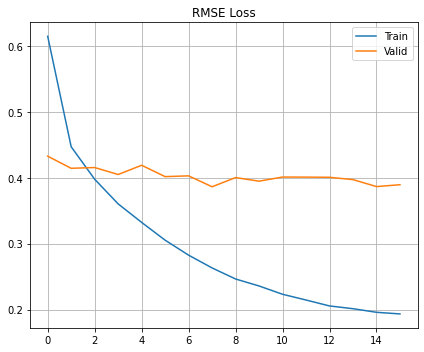

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_losses)
plt.plot(valid_losses)
plt.title('RMSE Loss')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

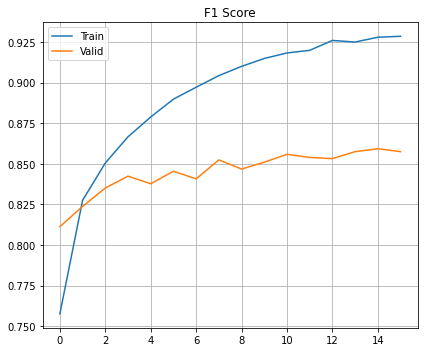

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_f1s)
plt.plot(valid_f1s)
plt.title('F1 Score')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

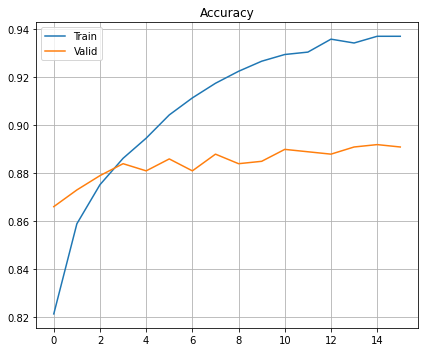

In [ ]:
plt.figure(figsize=(6,5))

plt.plot(train_acces)
plt.plot(valid_acces)
plt.title('Accuracy')
plt.legend(['Train','Valid'])
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import csv
                        ######여기 4로#####
with open('[Multi]n_layers=4.csv', 'w', newline='') as f: 
    writer = csv.writer(f) 
    writer.writerow(train_losses)
    writer.writerow(valid_losses)
    writer.writerow(train_f1s)
    writer.writerow(valid_f1s)

## **4. 모델 테스트**

In [ ]:
##############
# Test #
##############
model.eval()
test_f1 = 0
test_acc = 0
test_f1s = []
test_acces = []
y_actu =  []
y_pred = []

with torch.no_grad():
    for i, dict in enumerate(dataloader_test):
        audio = dict['audio'].to(device=device, dtype=torch.float32)
        input_ids = dict['input_ids'].to(device=device, dtype=torch.int32)
        token_type_ids = dict['token_type_ids'].to(device=device, dtype=torch.int32)
        attention_mask = dict['attention_mask'].to(device=device, dtype=torch.int32)
        targets = dict['emotion'].to(device=device, dtype=torch.long)

        scores, arousal, valence = model(audio, input_ids, token_type_ids, attention_mask)
        _, preds = scores.max(dim=1)

        test_acc += (targets == preds).sum() / preds.size(0)
        test_f1 += f1_score(targets.detach().cpu().numpy(), 
                          preds.detach().cpu().numpy(),
                          average='weighted')
        
        # confusion matrix
        y_actu.append(targets.cpu().detach().numpy())
        y_pred.append(preds.cpu().detach().numpy())
        
#######
# Log #
#######
test_f1s.append(test_f1 / len(dataloader_test))
test_acces.append(test_acc / len(dataloader_test))
print("Test F1: ", test_f1s[-1])
print("Test Accuracy: ", test_acces[-1])

Test F1:  0.8693896113234378
Test Accuracy:  tensor(0.8982, device='cuda:0')


Confusion Matrix

In [ ]:
y_actu = np.concatenate(y_actu, axis=0)
y_pred = np.concatenate(y_pred, axis=0)

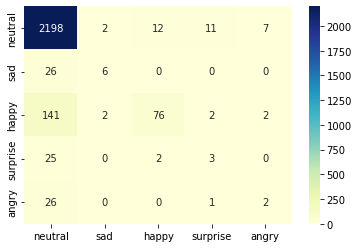

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

cm = confusion_matrix(y_actu, y_pred)
ax= plt.subplot()
f = sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap="YlGnBu")
ax.xaxis.set_ticklabels(['neutral', 'sad', 'happy', 'surprise', 'angry']); 
ax.yaxis.set_ticklabels(['neutral', 'sad', 'happy', 'surprise', 'angry']);

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


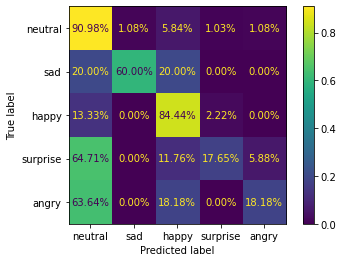

In [ ]:
IC = type('IdentityClassifier', (), {"predict": lambda i : i, "_estimator_type": "classifier"})
plot_confusion_matrix(IC, y_actu, y_pred, normalize='true', values_format='.2%',
                      display_labels=['neutral', 'sad', 'happy', 'surprise', 'angry']);
